In [108]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [109]:
import numpy as np
import pandas as pd

In [110]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [111]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [112]:
# Creating engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [113]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [114]:
# We can view all of the classes that automap found ('measurement', 'station')
Base.classes.keys()

['measurement', 'station']

In [115]:
# Save references to each table
# Measurment class key
Measurement = Base.classes.measurement
# Station class key
Station = Base.classes.station
# Print 
print("measurement reference: {measurement}\nstation reference: {station}")


measurement reference: {measurement}
station reference: {station}


In [116]:
# Create our session (link) from Python to the DB
session = Session(engine)
session


# Exploratory Climate Analysis

In [117]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# Add connection to use pandas
conn = engine.connect()

In [118]:
# Understanding/Querying the dataset of 'station'
station_df = pd.read_sql("SELECT * FROM station", conn)
station_df.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [119]:
# Query of measurment df
measurement_df = pd.read_sql("SELECT * FROM measurement", conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [120]:
measurement_df.columns

Index(['id', 'station', 'date', 'prcp', 'tobs'], dtype='object')

In [121]:
# Design a query to show how many stations are available in this dataset? Don't forget f string
station_count = session.query(station).count()
print(f"There are {station_count} stations in the dataset.")

There are 9 stations in the dataset.


In [122]:
# What are the most active stations? (i.e. what stations have the most rows)? # Use group by, ordery by, & desc
# List the stations and the counts in descending order.

station_list = session.query(station.id, func.count(station.id)).\
    filter(measurement.station == station.station).\
    group_by(station.id).\
    order_by(func.count(station.id).desc()).all()
#print
station_list


[(7, 2772),
 (1, 2724),
 (2, 2709),
 (6, 2669),
 (9, 2612),
 (3, 2202),
 (8, 1979),
 (4, 1372),
 (5, 511)]

In [123]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Finding lowest temperature by querying id
lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == Station.station).\
    filter(Station.id == 7).first()

# Finding highest temp
highest_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == Station.station).\
    filter(Station.id == 7).all()

# Finding mean temp 
avgerage_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Station.id == 7).all()

# using np.ravel
low_temp = np.ravel(lowest_temp)
high_temp = np.ravel(highest_temp)
avg_temp = np.ravel(avgerage_temp)

# Print statments. tobs = time of observation adjustmentsis 
print(f'Station 7 lowest time of observation adjustmentsis (temp) is {low_temp[0]}')
print(f'Station 7 highest time of observation adjustmentsis (temp) is {high_temp[0]}')
print(f'Station 7 average time of observation adjustmentsis (temp) is {round(avg_temp[0],2)}')


Station 7 lowest time of observation adjustmentsis (temp) is 54.0
Station 7 highest time of observation adjustmentsis (temp) is 85.0
Station 7 average time of observation adjustmentsis (temp) is 73.1


In [124]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_12_months = session.query(Measurement.date).\
    filter(Measurement.station == Station.station).\
    filter(Station.id == 7).\
    order_by(Measurement.date.desc()).first()[0]
last_date = dt.datetime.strptime(last_12_months,"%Y-%m-%d")
last_date

# figuring out time
one_year = last_date - dt.timedelta(days=365)
one_year

# Results
temp_results = session.query(Measurement.tobs).\
    filter(Measurement.station == Station.station).\
    filter(Station.id == 7).\
    filter(Measurement.date > one_year)
    
temp_df = pd.DataFrame(temp_results)


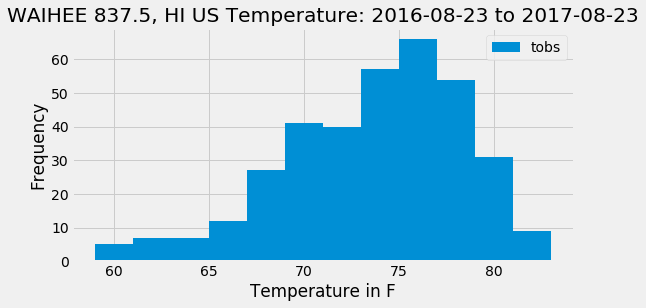

In [125]:
# Creatimg histogram and saving fig
temp_chart = temp_df.plot(kind='hist',bins=12, title="WAIHEE 837.5, HI US Temperature: 2016-08-23 to 2017-08-23", 
                          figsize=(8,4))
temp_chart.set_xlabel('Temperature in F')
temp_chart

# Save fig
plt.savefig("Station7-Temperature.png", bbox_inches = "tight")


In [126]:
# Perform a query to retrieve the data and precipitation scores
# Use the following info to create chart

# Query measurment data and prcp, filter the date. 
precipitation_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_results)
precipitation_df = precipitation_df.set_index('date')

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index(axis=0)

# Print
precipitation_df.head()

,prcp
date,
2016-08-19,0.04
2016-08-19,0.31
2016-08-19,0.07
2016-08-19,2.30
2016-08-19,0.14


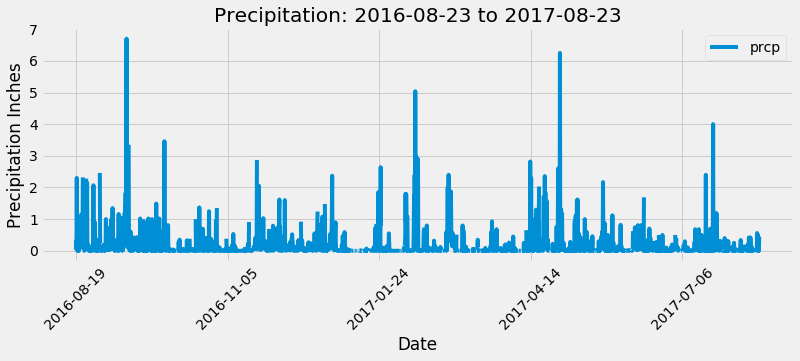

In [129]:
# Use Pandas Plotting with Matplotlib to plot the data
chart = precipitation_df.plot(use_index=True, rot=45, legend=True, 
                              title="Precipitation: 2016-08-23 to 2017-08-23", figsize=(12,4))
# X & Y chart title
chart.set_ylabel("Precipitation Inches")
chart.set_xlabel("Date")

# Save chart, use bbox_inches = "tight" so png does not get cut off
plt.savefig("Percipitation-2016-To-2017.png", bbox_inches = "tight")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
